In [177]:
# !pip install torch_scatter torch_sparse torch_cluster torch_spline_conv
# !pip install torch_geometric

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from timeit import default_timer as timer

from sklearn.utils import shuffle

from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

import warnings
warnings.filterwarnings("ignore")

In [179]:
# # If running in Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [180]:
output_path = 'output/models/'

In [181]:
# ls

In [182]:
# cd drive/MyDrive/RecSys_KB/Aleksis

In [183]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

In [184]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [185]:
movies.head()

,movieId,title,genres,abstracts,abstracts_count,abstract_embeddings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995) genres: Adventure|Animation|C...,0,[-3.30134444e-02 -2.01094374e-02 7.14708790e-...
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji is a 1995 American fantasy adventure f...,1,[-1.18304212e-02 6.41161203e-02 9.13541857e-...
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...,1,[-4.35247384e-02 -2.99240090e-02 -1.32443719e-...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale (1995) genres: Comedy|Drama|...,0,[-6.43825084e-02 -6.76364526e-02 -1.91318002e-...
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II (1995) genres: Comedy,0,[-4.51376252e-02 -5.00504188e-02 -1.56385768e-...


In [186]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [187]:
print("Any null values in movies:\n" , movies.isnull().sum())
print("Any null values in ratings train:\n ", ratings.isnull().sum())

Any null values in movies:
 movieId                0
title                  0
genres                 0
abstracts              0
abstracts_count        0
abstract_embeddings    0
dtype: int64
Any null values in ratings train:
  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [188]:
len(movies)

9742

In [189]:
len(movies['title'].unique())

9737

In [190]:
ratings['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [191]:
ratings['rating'].value_counts(ascending=False)

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [192]:
ratings['userId'].value_counts(ascending=True)

userId
442      20
406      20
147      20
194      20
569      20
       ... 
274    1346
448    1864
474    2108
599    2478
414    2698
Name: count, Length: 610, dtype: int64

In [193]:
ratings['movieId'].value_counts(ascending=True)

movieId
163981      1
142602      1
142961      1
5706        1
5468        1
         ... 
2571      278
593       279
296       307
318       317
356       329
Name: count, Length: 9724, dtype: int64

In [194]:
movie_ratings_count = ratings['movieId'].value_counts(ascending=True)

In [195]:
sum(ratings['movieId'].value_counts(ascending=True) == 1)

3446

In [196]:
# X_train, X_test, y_train, y_test = train_test_split(ratings[['userId', 'movieId']], ratings[['rating']], stratify=ratings[['rating']], test_size=0.20, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.10, random_state=42)

In [197]:
X_train, X_test = train_test_split(ratings[['userId', 'movieId', 'rating']], stratify=ratings[['rating']], test_size=0.20, random_state=42)
X_train, X_val = train_test_split(X_train, stratify=X_train[['rating']], test_size=0.10, random_state=42)

In [198]:
# X_train, X_test = train_test_split(ratings[['userId', 'movieId', 'rating']], test_size=0.20, random_state=42)
# X_train, X_val = train_test_split(X_train, test_size=0.10, random_state=42)

In [199]:
# X_train, X_test, y_train, y_test = train_test_split(ratings[['userId', 'movieId']], ratings[['rating']], test_size=0.10, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [200]:
users_train = X_train.userId.unique()

In [201]:
users_train = X_train.userId.unique()
movies_train = X_train.movieId.unique()

In [202]:
movies_with_enough_ratings = list(filter(lambda x: movie_ratings_count[x] >= 0, movies_train))

In [203]:
len(movies_with_enough_ratings)

8661

In [204]:
userid2idx = {o:i + 1 for i,o in enumerate(users_train)}
# userid2idx = {o:i + 1 for i,o in enumerate(ratings.userId.unique())}
# movieid2idx = {o:i + 1 for i,o in enumerate(movies_with_enough_ratings)}
movieid2idx = {o:i + 1 for i,o in enumerate(ratings.movieId.unique())}

In [205]:
userid2idx = {o:i for i,o in enumerate(users_train)}
# userid2idx = {o:i + 1 for i,o in enumerate(ratings.userId.unique())}
# movieid2idx = {o:i + 1 for i,o in enumerate(movies_with_enough_ratings)}
movieid2idx = {o:i for i,o in enumerate(ratings.movieId.unique())}

In [206]:
idx2userid = {v:k  for k,v in userid2idx.items()}
idx2movieid = {v:k  for k,v in movieid2idx.items()}

In [207]:
# userid2idx[-1] = 0 # unk user
# movieid2idx[-1] = 0 # unk movie

In [208]:
len(userid2idx), len(movieid2idx)

(610, 9724)

In [209]:
num_users, num_movies = len(userid2idx), len(movieid2idx)
num_users, num_movies

(610, 9724)

In [210]:
def get_index(data):
    data['userId'] = data['userId'].apply(lambda x: userid2idx.get(x, 0))
    data['movieId'] = data['movieId'].apply(lambda x: movieid2idx.get(x, 0))

In [211]:
movies

,movieId,title,genres,abstracts,abstracts_count,abstract_embeddings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995) genres: Adventure|Animation|C...,0,[-3.30134444e-02 -2.01094374e-02 7.14708790e-...
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji is a 1995 American fantasy adventure f...,1,[-1.18304212e-02 6.41161203e-02 9.13541857e-...
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...,1,[-4.35247384e-02 -2.99240090e-02 -1.32443719e-...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale (1995) genres: Comedy|Drama|...,0,[-6.43825084e-02 -6.76364526e-02 -1.91318002e-...
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II (1995) genres: Comedy,0,[-4.51376252e-02 -5.00504188e-02 -1.56385768e-...
...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,The Butler Bulldogs men's basketball team repr...,2,[ 3.13083529e-02 1.48075968e-02 3.68007384e-...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"No Game No Life (Japanese: ノーゲーム・ノーライフ, Hepbur...",1,[-1.92668010e-02 -4.74059843e-02 -8.06948766e-...
9739,193585,Flint (2017),Drama,Flint is a sedimentary cryptocrystalline form ...,1,[-5.53447567e-02 -1.97313577e-02 3.11960699e-...
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"Bungo Stray Dogs (Japanese: 文豪ストレイドッグス, Hepbur...",2,[-1.11603690e-03 -6.92510679e-02 1.85637157e-...


In [212]:
movies['genres'].isna().any()

False

In [213]:
genres = set()
for genre in movies['genres']:
    genres.update(genre.split('|'))

In [214]:
genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [215]:
le = OneHotEncoder()
le.fit(np.array(list(genres)).reshape(-1, 1))

OneHotEncoder()

In [216]:
le.categories_

[array(['(no genres listed)', 'Action', 'Adventure', 'Animation',
        'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
        'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
        'Sci-Fi', 'Thriller', 'War', 'Western'], dtype='<U18')]

In [217]:
le.transform([['Fantasy'], ['Children']]).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [218]:
sum(le.transform([['Fantasy'], ['Children']]).toarray())

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [219]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [220]:
sum(le.transform(np.array(movies[movies['movieId'] == 1]['genres'].values[0].split('|')).reshape(-1, 1)).toarray())

array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [221]:
movies

,movieId,title,genres,abstracts,abstracts_count,abstract_embeddings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995) genres: Adventure|Animation|C...,0,[-3.30134444e-02 -2.01094374e-02 7.14708790e-...
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji is a 1995 American fantasy adventure f...,1,[-1.18304212e-02 6.41161203e-02 9.13541857e-...
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...,1,[-4.35247384e-02 -2.99240090e-02 -1.32443719e-...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale (1995) genres: Comedy|Drama|...,0,[-6.43825084e-02 -6.76364526e-02 -1.91318002e-...
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II (1995) genres: Comedy,0,[-4.51376252e-02 -5.00504188e-02 -1.56385768e-...
...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,The Butler Bulldogs men's basketball team repr...,2,[ 3.13083529e-02 1.48075968e-02 3.68007384e-...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"No Game No Life (Japanese: ノーゲーム・ノーライフ, Hepbur...",1,[-1.92668010e-02 -4.74059843e-02 -8.06948766e-...
9739,193585,Flint (2017),Drama,Flint is a sedimentary cryptocrystalline form ...,1,[-5.53447567e-02 -1.97313577e-02 3.11960699e-...
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"Bungo Stray Dogs (Japanese: 文豪ストレイドッグス, Hepbur...",2,[-1.11603690e-03 -6.92510679e-02 1.85637157e-...


In [222]:
# movie2genre_vec = {}
# for i, row in movies.iterrows():
#     movie2genre_vec[row['movieId']] = sum(le.transform(np.array(row['genres'].split('|')).reshape(-1, 1)).toarray())

In [223]:
# movie2genre_vec[1]

In [224]:
def get_edge_index(X): # , y):
    edge_index = [[], []]
    edge_values = []
    for i, row in X.iterrows():
        edge_index[0].append(userid2idx.get(row['userId'], 0))
        edge_index[1].append(movieid2idx.get(row['movieId'], 0))
        edge_values.append(row['rating'])

    return edge_index, edge_values #y['rating'].to_list()

In [225]:
# get_edge_index(X_train)

In [226]:
edge_index_train, edge_values_train = get_edge_index(X_train)
edge_index_val, edge_values_val     = get_edge_index(X_val)
edge_index_test, edge_values_test = get_edge_index(X_test)

In [227]:
len(edge_index_train[0]), len(edge_values_train)

(72601, 72601)

In [228]:
np.array(edge_index_train)[0]

array([ 0,  1,  2, ..., 57,  3, 38])

In [229]:
np.array(edge_index_train).shape

(2, 72601)

In [230]:
len(edge_index_train[0])

72601

In [231]:
len(edge_index_train[0]) + len(edge_index_val[0]) + len(edge_index_test[0])

100836

In [232]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, input_edge_values):

    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
                                           col=input_edge_index[1],
                                           value = input_edge_values,
                                           sparse_sizes=((num_users + num_movies), num_users + num_movies))

    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]

    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    r_mat_edge_values = interact_mat.to_sparse_coo().values()

    return r_mat_edge_index, r_mat_edge_values

In [233]:
torch.tensor(edge_index_train).shape

torch.Size([2, 72601])

In [234]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, input_edge_values):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = input_edge_values[i] # assign actual edge value to Interaction Matrix

    R_transpose = torch.transpose(R, 0, 1)

    # create adj_matrix
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()

    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo_indices = adj_mat_coo.indices()
    adj_mat_coo_values = adj_mat_coo.values()
    return adj_mat_coo_indices, adj_mat_coo_values

In [235]:
edge_index_train, edge_values_train = torch.tensor(edge_index_train), torch.tensor(edge_values_train)
edge_index_val,   edge_values_val   = torch.tensor(edge_index_val), torch.tensor(  edge_values_val)  
edge_index_test, edge_values_test   = torch.tensor(edge_index_test), torch.tensor(edge_values_test)  

In [236]:
edge_index_train[1].max()

tensor(9722)

In [237]:
adj_edge_index_train, adj_edge_values_train  = convert_r_mat_edge_index_to_adj_mat_edge_index(  edge_index_train, edge_values_train)
adj_edge_index_val, adj_edge_values_val     = convert_r_mat_edge_index_to_adj_mat_edge_index(   edge_index_val,   edge_values_val  )
adj_edge_index_test, adj_edge_values_test   = convert_r_mat_edge_index_to_adj_mat_edge_index(   edge_index_test, edge_values_test  )

In [238]:
adj_edge_index_train.shape

torch.Size([2, 145202])

In [239]:
# r_mat_edge_index_train.shape, r_mat_edge_values_train.shape

In [240]:
# r_mat_edge_index_train, r_mat_edge_values_train   = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index_train,    edge_values_train)
# r_mat_edge_index_val,   r_mat_edge_values_val     = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index_val,      edge_values_val)
# r_mat_edge_index_test,  r_mat_edge_values_test    = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index_test,     edge_values_test)

In [241]:
r_mat_edge_index_train, r_mat_edge_values_train   = convert_adj_mat_edge_index_to_r_mat_edge_index(adj_edge_index_train, adj_edge_values_train)
r_mat_edge_index_val,   r_mat_edge_values_val     = convert_adj_mat_edge_index_to_r_mat_edge_index(adj_edge_index_val, adj_edge_values_val    )
r_mat_edge_index_test,  r_mat_edge_values_test    = convert_adj_mat_edge_index_to_r_mat_edge_index(adj_edge_index_test, adj_edge_values_test  )

In [242]:
r_mat_edge_index_train.shape

torch.Size([2, 72601])

In [243]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, input_edge_values):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = input_edge_values[i] # assign actual edge value to Interaction Matrix

    R_transpose = torch.transpose(R, 0, 1)

    # create adj_matrix
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()

    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo_indices = adj_mat_coo.indices()
    adj_mat_coo_values = adj_mat_coo.values()
    return adj_mat_coo_indices, adj_mat_coo_values

In [244]:
# edge_index_train, edge_value_train = convert_r_mat_edge_index_to_adj_mat_edge_index(adj_edge_index_train, adj_edge_values_train)
# edge_index_val, edge_value_val = convert_r_mat_edge_index_to_adj_mat_edge_index(sparse_edge_index_val, sparse_edge_values_val)
# edge_index_test, edge_value_test = convert_r_mat_edge_index_to_adj_mat_edge_index(adj_edge_index_test, adj_edge_values_test)

In [245]:
# adj_edge_index_train.shape

In [246]:
edge_index_train.shape

torch.Size([2, 72601])

In [247]:
# device = 'cpu'

In [248]:
# device = 'cuda:0'

In [249]:
edge_index_train = edge_index_train.to(device)

In [250]:
def train_step(model,
               edge_index_train,
               r_mat_edge_index_train,
               r_mat_edge_values_train,
               loss_fn,
               optimizer,
               device):

    model.train()
    y_pred = model(edge_index_train, r_mat_edge_index_train)

    loss = loss_fn(y_pred, r_mat_edge_values_train.view(-1, 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def test_step(model,
              edge_index_test,
              r_mat_edge_index_test,
              r_mat_edge_values_test,
              loss_fn,
              device):
    model.eval()

    with torch.inference_mode():

        y_pred = model(edge_index_test, r_mat_edge_index_test)

        loss = loss_fn(y_pred, r_mat_edge_values_test.view(-1, 1))

        return loss.item()

def train(model,
          optimizer,
          loss_fn,
          epochs,
          device,
          scheduler,
          edge_index_train=adj_edge_index_train,
          r_mat_edge_index_train=r_mat_edge_index_train,
          r_mat_edge_values_train=r_mat_edge_values_train,
          edge_index_test=adj_edge_index_val,
          r_mat_edge_index_test=r_mat_edge_index_val,
          r_mat_edge_values_test=r_mat_edge_values_val,
          results = {"train_loss": [],
               "test_loss": [],
    }
):
    model.to(device)

    best_loss = float('inf')

    edge_index_train = edge_index_train.to(device)
    r_mat_edge_index_train = r_mat_edge_index_train.to(device)
    r_mat_edge_values_train = r_mat_edge_values_train.float().to(device)
    edge_index_test = edge_index_test.to(device)
    r_mat_edge_index_test = r_mat_edge_index_test.to(device)
    r_mat_edge_values_test = r_mat_edge_values_test.float().to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss = train_step(model=model,
                                edge_index_train=edge_index_train,
                                r_mat_edge_index_train=r_mat_edge_index_train,
                                r_mat_edge_values_train=r_mat_edge_values_train,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        end_time = timer()
        test_loss = test_step(model=model,
                              edge_index_test=edge_index_test,
                              r_mat_edge_index_test=r_mat_edge_index_test,
                              r_mat_edge_values_test=r_mat_edge_values_test,
                              loss_fn=loss_fn,
                              device=device)

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        if epoch % 200 == 0 and epoch != 0:
            scheduler.step()

            if best_loss > test_loss:
                best_loss = test_loss
                print('Saving new best model.')
                model.save( output_path + model.name + ".pt")



            print(
              f"Epoch: {epoch} | "
              f"train_loss: {train_loss:.4f} | "
              f"train RMSE: {np.sqrt(train_loss):.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test RMSE: {np.sqrt(test_loss):.4f} | "
              f"time: {(end_time-start_time):.4f} "
              f"Learning rate: {next(iter(scheduler.optimizer.param_groups))['lr']}"
            )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

In [251]:
adj_edge_index_train.shape, r_mat_edge_index_train.shape, r_mat_edge_values_train.shape

(torch.Size([2, 145202]), torch.Size([2, 72601]), torch.Size([72601]))

In [252]:
adj_edge_index_train, r_mat_edge_index_train, r_mat_edge_values_train

(tensor([[    0,     0,     0,  ..., 10329, 10330, 10332],
         [  610,   614,   617,  ...,    13,    13,    13]]),
 tensor([[   0,    0,    0,  ...,  609,  609,  609],
         [   0,    4,    7,  ...,  902,  915, 1925]]),
 tensor([3.0000, 4.5000, 4.0000,  ..., 4.5000, 4.5000, 4.0000]))

In [253]:
# edge_index_train=edge_index_train,
#           adj_edge_index_train=adj_edge_index_train,
#           adj_edge_values_train=adj_edge_values_train,
#           edge_index_test=edge_index_test,
#           adj_edge_index_test=adj_edge_index_test,
#           adj_edge_values_test=adj_edge_values_test,

In [254]:
# defines LightGCN model
class LightGCN(MessagePassing):

    def save(self, fileName):
        torch.save(self.state_dict(), fileName)

    def load(self, fileName, device):
        self.load_state_dict(torch.load(fileName, map_location=device))

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False, dropout_rate=0.1, name='name'):

        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops
        self.name = name
        self.drop1 = nn.Dropout(dropout_rate)

        # define user and item embedding for direct look up.
        # embedding dimension: num_user/num_item x embedding_dim
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0

        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0


        # "Fills the input Tensor with values drawn from the normal distribution"
        # according to LightGCN paper, this gives better performance
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

        # create a linear layer (fully connected layer) so we can output a single value (predicted_rating)
        self.out = nn.Linear(embedding_dim + embedding_dim, 1)

    def forward(self, edge_index, r_mat_edge_index):
        edge_index_norm = gcn_norm(edge_index=edge_index,
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embing matrix
        # size will be (n_users + n_items) x emb_vector_len.   e.g: 10334 x 64
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list

        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)


        # this is doing the formula8 in LightGCN paper

        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x emb_vector_len.
        #        e.g: torch.Size([10334, 4, 64])
        embs = torch.stack(embs, dim=1)

        # From LightGCn paper: "In our experiments, we find that setting α_k uniformly as 1/(K + 1)
        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(emb_final,
                                                       [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        src, dest =  r_mat_edge_index[0], r_mat_edge_index[1]

        # applying embedding lookup to get embeddings for src nodes and dest nodes in the edge list
        user_embeds = users_emb_final[src]
        item_embeds = items_emb_final[dest]

        # output dim: edge_index_len x 128 (given 64 is the original emb_vector_len)
        x = torch.cat([user_embeds, item_embeds], dim=1)

        x = self.drop1(x)

        # push it through the linear layer
        output = self.out(x)

        return output

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j


In [255]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat ,y))

In [256]:
model = LightGCN(num_users=num_users, num_items=num_movies, embedding_dim=64, K=2, add_self_loops=True, dropout_rate=0.5, name="light_gcn") # best 0.9504
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=0.0001, threshold_mode='rel')

  0%|          | 0/15000 [00:00<?, ?it/s]

Saving new best model.
Epoch: 200 | train_loss: 2.6891 | train RMSE: 1.6398 | test_loss: 2.7821 | test RMSE: 1.6680 | time: 0.0075 Learning rate: 0.00095
Saving new best model.
Epoch: 400 | train_loss: 1.8042 | train RMSE: 1.3432 | test_loss: 1.8120 | test RMSE: 1.3461 | time: 0.0092 Learning rate: 0.0009025
Saving new best model.
Epoch: 600 | train_loss: 1.5480 | train RMSE: 1.2442 | test_loss: 1.5375 | test RMSE: 1.2400 | time: 0.0089 Learning rate: 0.000857375
Saving new best model.
Epoch: 800 | train_loss: 1.4100 | train RMSE: 1.1874 | test_loss: 1.3998 | test RMSE: 1.1831 | time: 0.0089 Learning rate: 0.0008145062499999999
Saving new best model.
Epoch: 1000 | train_loss: 1.3219 | train RMSE: 1.1497 | test_loss: 1.3128 | test RMSE: 1.1458 | time: 0.0091 Learning rate: 0.0007737809374999998
Saving new best model.
Epoch: 1200 | train_loss: 1.2575 | train RMSE: 1.1214 | test_loss: 1.2520 | test RMSE: 1.1190 | time: 0.0076 Learning rate: 0.0007350918906249997
Saving new best model.
Epo

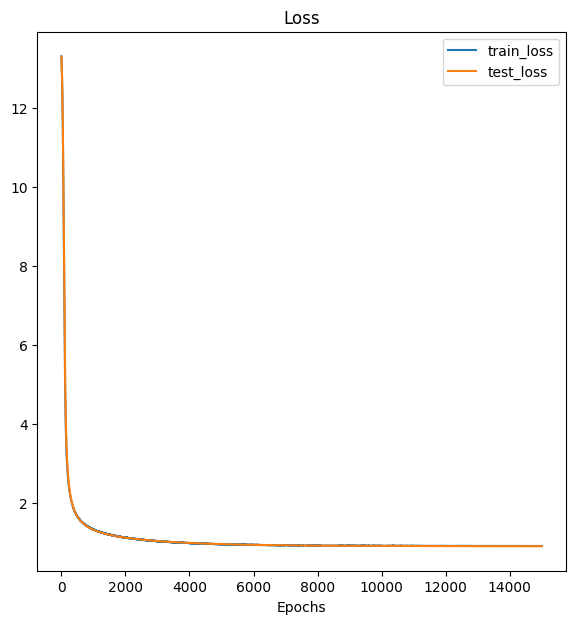

In [257]:
results = train(model=model, #  test_loss: 0.7769 | test RMSE: 0.8814
          optimizer = optimizer,
          loss_fn = nn.MSELoss(),                              
          epochs = 15_000,
          device = device,
          scheduler=scheduler)
plot_loss_curves(results)

In [258]:
# defines LightGCN model
class DeepLightGCN(MessagePassing):

    def save(self, fileName):
        torch.save(self.state_dict(), fileName)

    def load(self, fileName, device):
        self.load_state_dict(torch.load(fileName, map_location=device))

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, n_hidden=32, add_self_loops=False, dropout_rate=0.1, name='name'):

        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops
        self.name = name
        self.drop1 = nn.Dropout(dropout_rate)
        self.drop2 = nn.Dropout(dropout_rate)

        # define user and item embedding for direct look up.
        # embedding dimension: num_user/num_item x embedding_dim
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0

        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0


        # "Fills the input Tensor with values drawn from the normal distribution"
        # according to LightGCN paper, this gives better performance
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

        self.lin1 = nn.Linear(embedding_dim*2, n_hidden)
        # create a linear layer (fully connected layer) so we can output a single value (predicted_rating)
        self.out = nn.Linear(n_hidden, 1)

    def forward(self, edge_index, r_mat_edge_index):
        edge_index_norm = gcn_norm(edge_index=edge_index,
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embing matrix
        # size will be (n_users + n_items) x emb_vector_len.   e.g: 10334 x 64
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list

        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)


        # this is doing the formula8 in LightGCN paper

        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x emb_vector_len.
        #        e.g: torch.Size([10334, 4, 64])
        embs = torch.stack(embs, dim=1)

        # From LightGCn paper: "In our experiments, we find that setting α_k uniformly as 1/(K + 1)
        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(emb_final,
                                                       [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        src, dest =  r_mat_edge_index[0], r_mat_edge_index[1]

        # applying embedding lookup to get embeddings for src nodes and dest nodes in the edge list
        user_embeds = users_emb_final[src]
        item_embeds = items_emb_final[dest]

        # output dim: edge_index_len x 128 (given 64 is the original emb_vector_len)
        x = torch.cat([user_embeds, item_embeds], dim=1)

        x = self.drop1(x)

        x = self.lin1(x)

        x = self.drop2(x)
        # push it through the linear layer
        output = self.out(x)

        return output

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j


In [259]:
model = DeepLightGCN(num_users=num_users, num_items=num_movies, embedding_dim=64, K=2, n_hidden=64, add_self_loops=True, dropout_rate=0.5, name="light_gcn_v2") # best 0.9504
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=0.0001, threshold_mode='rel')

  0%|          | 0/15000 [00:00<?, ?it/s]

Saving new best model.
Epoch: 200 | train_loss: 1.1849 | train RMSE: 1.0885 | test_loss: 0.9707 | test RMSE: 0.9852 | time: 0.0092 Learning rate: 0.00095
Saving new best model.
Epoch: 400 | train_loss: 1.0168 | train RMSE: 1.0084 | test_loss: 0.8480 | test RMSE: 0.9209 | time: 0.0114 Learning rate: 0.0009025
Saving new best model.
Epoch: 600 | train_loss: 1.0071 | train RMSE: 1.0036 | test_loss: 0.8236 | test RMSE: 0.9075 | time: 0.0104 Learning rate: 0.000857375
Epoch: 800 | train_loss: 1.0017 | train RMSE: 1.0008 | test_loss: 0.8258 | test RMSE: 0.9087 | time: 0.0107 Learning rate: 0.0008145062499999999
Epoch: 1000 | train_loss: 0.9918 | train RMSE: 0.9959 | test_loss: 0.8256 | test RMSE: 0.9086 | time: 0.0123 Learning rate: 0.0007737809374999998
Epoch: 1200 | train_loss: 0.9869 | train RMSE: 0.9934 | test_loss: 0.8245 | test RMSE: 0.9080 | time: 0.0123 Learning rate: 0.0007350918906249997
Saving new best model.
Epoch: 1400 | train_loss: 0.9796 | train RMSE: 0.9898 | test_loss: 0.821

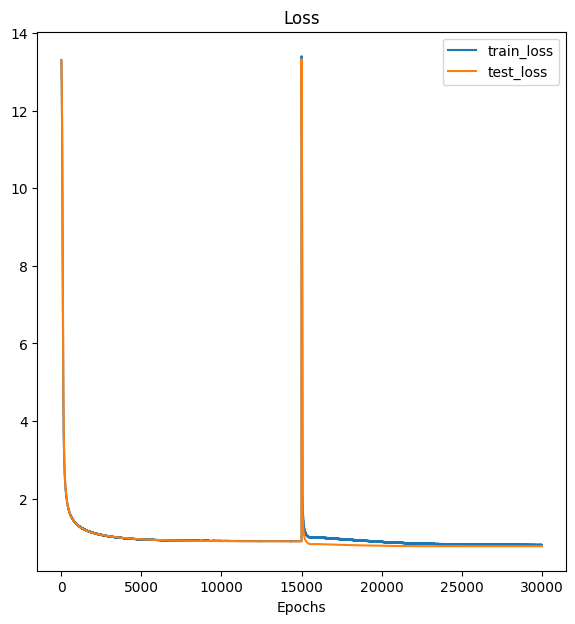

In [260]:
results = train(model=model, #  test_loss: 0.7721 | test RMSE: 0.8787 
          optimizer = optimizer,
          loss_fn = nn.MSELoss(),                              
          epochs = 15_000,
          device = device,
          scheduler=scheduler)
plot_loss_curves(results)

In [261]:
edge_index_train[0].max()

tensor(609, device='cuda:0')

In [262]:
edge_index_train.shape

torch.Size([2, 72601])

In [263]:
adj_edge_index_train.shape

torch.Size([2, 145202])

In [264]:
# len(edge_value_train)